In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


In [2]:
# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [3]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Extracting DATA_MNIST/MNIST\raw\train-images-idx3-ubyte.gz to DATA_MNIST/MNIST\raw


Extracting DATA_MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST\raw


Extracting DATA_MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST\raw




Extracting DATA_MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST\raw
Processing...


I:\Miniconda\envs\rlenv\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data) 
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


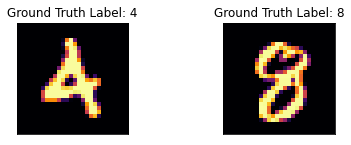

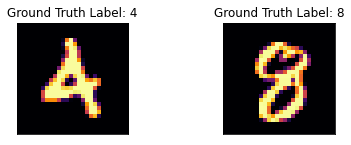

In [8]:
fig = plt.figure()
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

In [9]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
               
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2), 
            
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size=2) 
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(in_features=64, out_features=10)
        )

    # Forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

In [10]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [12]:

epochs = 10 # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0

        
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/10   Training loss: 0.7570   Testing loss: 0.2436   Test accuracy: 0.9254  
Epoch: 2/10   Training loss: 0.2181   Testing loss: 0.1233   Test accuracy: 0.9616  
Epoch: 3/10   Training loss: 0.1513   Testing loss: 0.0972   Test accuracy: 0.9690  
Epoch: 4/10   Training loss: 0.1201   Testing loss: 0.0737   Test accuracy: 0.9763  
Epoch: 5/10   Training loss: 0.1036   Testing loss: 0.0636   Test accuracy: 0.9788  
Epoch: 6/10   Training loss: 0.0908   Testing loss: 0.0676   Test accuracy: 0.9768  
Epoch: 7/10   Training loss: 0.0812   Testing loss: 0.0506   Test accuracy: 0.9834  
Epoch: 8/10   Training loss: 0.0761   Testing loss: 0.0510   Test accuracy: 0.9827  
Epoch: 9/10   Training loss: 0.0687   Testing loss: 0.0480   Test accuracy: 0.9852  
Epoch: 10/10   Training loss: 0.0641   Testing loss: 0.0500   Test accuracy: 0.9836  


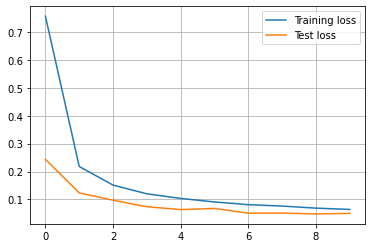

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()

In [14]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[9.9983704e-01 1.4581756e-09 6.7534700e-07 6.0638077e-09 7.1980971e-08
 2.6205746e-05 1.2761624e-04 1.6615112e-06 1.0138257e-06 5.5709816e-06]


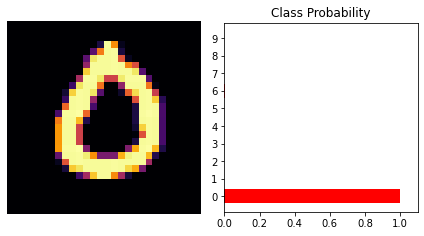

In [15]:

# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()